! pip install numpy networkx pandas dowhy seaborn dodiscover

In [2]:
! pip install dodiscover

ERROR: Could not find a version that satisfies the requirement dodiscover (from versions: none)
ERROR: No matching distribution found for dodiscover


In [3]:
import dodiscover

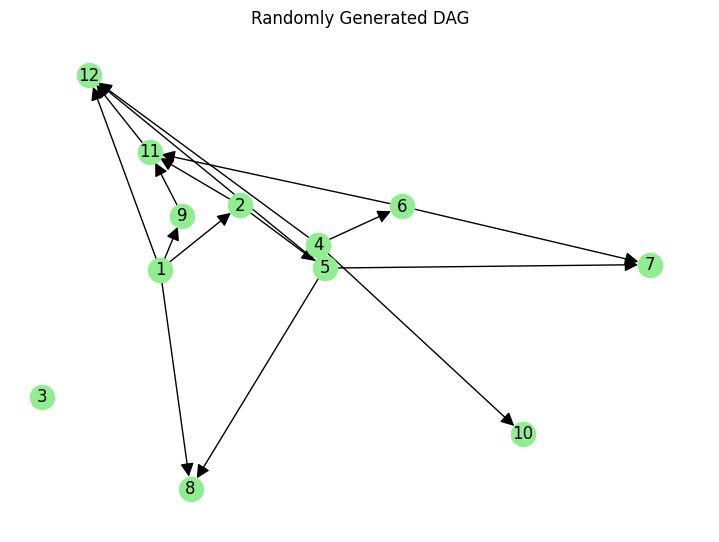

In [15]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from dodiscover import make_context
from dodiscover.toporder.score import SCORE
from sklearn.preprocessing import StandardScaler
import networkx as nx

def generate_random_dag(n_nodes, edge_prob=0.3, seed=None):
    """
    Generate a random DAG with a given number of nodes and edge probability.
    
    Parameters:
        Node_numbers (int): Number of nodes in the DAG.
        edge_prob (float): Probability of adding an edge between nodes.
        
    Returns:
        nx.DiGraph: Generated DAG.
    """
    rng = np.random.default_rng(seed)
    adj = np.triu(rng.random((n_nodes, n_nodes)) < edge_prob, 1)
    G = nx.from_numpy_array(adj, create_using=nx.DiGraph)
    mapping = {i: f"{i+1}" for i in range(n_nodes)}
    G = nx.relabel_nodes(G, mapping)
    # stable version
    # nodes = np.arange(n_nodes)
    # np.random.shuffle(nodes)
    # G = nx.DiGraph()
    # G.add_nodes_from(nodes)
    # for i in range(n_nodes-1):
    #     for j in range(i+1, n_nodes):
    #         if np.random.rand()< edge_prob:
    #             G.add_edge(nodes[i], nodes[j])
    return G

def plot_dag(G):
    """
    Plots a directed acyclic graph (DAG) using networkx and matplotlib.
    Args:
        G (networkx.DiGraph): The DAG to plot.
    """
    plt.figure(figsize=(7, 5))
    pos = nx.spring_layout(G, seed=42)  # or use nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=300, arrowsize=20)
    plt.title("Randomly Generated DAG")
    plt.show()

num_nodes = 12  # Adjust this number for larger graphs
edge_prob = 0.2  # Probability of adding an edge between nodes

G = generate_random_dag(num_nodes, edge_prob)


plot_dag(G)




In [16]:
def generate_scm(n_samples, relations, noise_std=1.0, seed=None):
    """
    Generate data from a nonlinear additive SCM with Gaussian noise.
    
    Parameters:
        n_samples (int): Number of samples to generate.
        relations (list of callables): Each function defines X_i in terms of previous Xs and noise.
        noise_std (float or list): Standard deviation(s) for Gaussian noise.
        seed (int): Random seed for reproducibility.
        
    Returns:
        pd.DataFrame: Generated data with columns X1, X2, ..., Xn.
    """
    rng = np.random.default_rng(seed)
    n_vars = len(relations)
    X = np.zeros((n_samples, n_vars))
    if isinstance(noise_std, (float, int)):
        noise_std = [noise_std] * n_vars

    for i, rel in enumerate(relations):
        noise = rng.normal(0, noise_std[i], size=n_samples)
        X[:, i] = rel(X, noise)
    columns = [f"X{i+1}" for i in range(n_vars)]
    
    return pd.DataFrame(X, columns=columns)

def get_topological_order(df, method='SCORE', **kwargs):
    """
    Get the topological order of variables using specified causal discovery method.
    
    Parameters:
        df (pd.DataFrame): Input data
        method (str): Causal discovery method to use ('SCORE', 'DAS', 'NoGAM', 'CAM')
        **kwargs: Additional arguments to pass to the causal discovery method
        
    Returns:
        list: Topological order of variables
    """
    # Standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(X, columns=df.columns)
    
    # Create context for causal discovery
    context = make_context().variables(data=df_scaled).build()
    
    # Initialize the causal discovery method
    if method == 'SCORE':
        cd_method = SCORE(**kwargs)
    elif method == 'DAS':
        from dodiscover.toporder.das import DAS
        cd_method = DAS(**kwargs)
    elif method == 'NoGAM':
        from dodiscover.toporder.nogam import NoGAM
        cd_method = NoGAM(**kwargs)
    elif method == 'CAM':
        from dodiscover.toporder.cam import CAM
        cd_method = CAM(**kwargs)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Learn the causal graph
    cd_method.learn_graph(df_scaled, context)

    # SCORE estimates a directed acyclic graph (DAG) and the topoological order
    # of the nodes in the graph. SCORE is consistent in the infinite samples
    # limit, meaning that it might return faulty estimates due to the finiteness
    # of the data.
    graph = cd_method.graph_
    order_graph = cd_method.order_graph_
    print(list(nx.topological_sort(order_graph)))
    return list(nx.topological_sort(order_graph)), graph



In [17]:
relations = [
    lambda X, N: X[:, 0],  # X1 = exogenous (will be overwritten by noise)
    lambda X, N: np.tanh(X[:, 2]) + N,  # X2 = tanh(X3) + N2
    lambda X, N: np.sinc(X[:, 0]) + N,  # X3 = sinc(X1) + N3
    lambda X, N: X[:, 0]**3 - X[:, 0] + N,  # X4 = X1^3 - X1 + N4
    lambda X, N: X[:, 3] * np.sin(X[:, 2]) + N,  # X5 = X4 * sin(X3) + N5
]

n_samples = 1000
# For X1, just use noise (exogenous)
relations[0] = lambda X, N: N  # X1 = N1

data = generate_scm(n_samples, relations, noise_std=1.0, seed=42)
print(data.head())
def plot_data_distributions(data):
    """
    Visualize pairwise relationships and marginal distributions.
    """
    sns.pairplot(data, diag_kind="kde", plot_kws={'alpha':0.5, 's':20})
    plt.suptitle("Pairwise Scatterplots and Marginals", y=1.02)
    plt.show()

# plot_data_distributions(data)

top_order, graph = get_topological_order(data, method='SCORE')
print(top_order)


         X1        X2        X3        X4        X5
0  0.304717 -0.059283  0.402161  0.972599  0.633887
1 -1.039984 -0.729287 -0.704224  0.602864  0.504899
2  0.750451 -0.414473  0.733509  1.638313  1.370140
3  0.940565  0.633910  0.314679 -1.656316  1.726183
4 -1.951035  0.002993 -1.429790 -5.741015  7.113823
['X1', 'X4', 'X3', 'X5', 'X2']
['X1', 'X4', 'X3', 'X5', 'X2']


In [ ]:
def f1(X, noise):
        return noise
def f2(X, noise):
        return 0.5 * X[:, 0] + noise
    
def f3(X, noise):
        return 0.3 * X[:, 0] + 0.7 * X[:, 1] + noise